# Bengali Character Recognition using CNN

This notebook implements a Convolutional Neural Network (CNN) to recognize Bengali characters using the Ekush dataset.

The dataset contains 122 classes of Bengali characters (folders named 0 to 121), with images of size 28x28 (black background with white characters).

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# Make sure required modules are imported
if 'autocast' not in globals():
    from torch.cuda.amp import autocast
    
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import autocast, GradScaler  # Updated import path
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm.notebook import tqdm  # Using regular tqdm instead of notebook version
import random
import time
from datetime import datetime

# Print current system info
print(f"Current Time: 2025-05-17 10:47:40")
print(f"User: bodhdipta-roy")
print(f"PyTorch Version: {torch.__version__}")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Current Time: 2025-05-17 10:47:40
User: bodhdipta-roy
PyTorch Version: 2.7.0+cu128


## 2. GPU Configuration and Optimization

In [2]:
# GPU Configuration
# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    # Get GPU details
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Enhanced GPU optimization for RTX 4060 8GB
    cudnn.benchmark = True  # Optimize for fixed input sizes (faster)
    cudnn.deterministic = False  # Disable deterministic mode for better performance
    torch.cuda.empty_cache()  # Clear GPU cache
    
    # Enable TF32 precision for RTX GPUs (faster than FP32, almost as accurate)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # Set memory allocation strategy to maximize available memory
    if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
        torch.cuda.set_per_process_memory_fraction(0.95)  # Use 95% of available GPU memory
    
    # Enable caching allocator for faster memory operations
    torch.cuda.empty_cache()
    
    # Configure JIT compilation for optimized CUDA kernels
    if hasattr(torch._C, '_jit_set_profiling_executor'):
        torch._C._jit_set_profiling_executor(True)
        torch._C._jit_set_profiling_mode(True)
    
    print("Advanced GPU optimization settings applied for RTX 4060 8GB")
else:
    print("CUDA not available. Using CPU.")
    
# Function to print detailed GPU memory usage and performance
def print_gpu_memory_stats():
    if torch.cuda.is_available():
        print(f"\n--- GPU Memory and Performance Summary ---")
        print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"  Reserved:  {torch.cuda.memory_reserved() / 1e9:.2f} GB")
        
        # Get detailed memory statistics for current device
        stats = torch.cuda.memory_stats()
        print(f"  Active allocated: {stats.get('active_bytes.all.allocated', 0) / 1e9:.2f} GB")
        print(f"  Active reserved: {stats.get('active_bytes.all.reserved', 0) / 1e9:.2f} GB")
        
        # Calculate memory efficiency
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        if reserved > 0:
            efficiency = (allocated / reserved) * 100
            print(f"  Memory efficiency: {efficiency:.2f}%")
        
        # Try to get GPU utilization if pynvml is available
        try:
            import pynvml
            pynvml.nvmlInit()
            handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            utilization = pynvml.nvmlDeviceGetUtilizationRates(handle)
            print(f"  GPU Utilization: {utilization.gpu}%")
            print(f"  Memory Utilization: {utilization.memory}%")
            pynvml.nvmlShutdown()
        except (ImportError, Exception):
            print(f"  GPU Utilization: Not available (pynvml not installed)")
        
        print("------------------------------------------")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.59 GB
Advanced GPU optimization settings applied for RTX 4060 8GB
Advanced GPU optimization settings applied for RTX 4060 8GB


## 3. Data Loading and Preprocessing

In [3]:
# Load the CSV file containing the class labels
# Update the path as per your system
csv_path = '/mnt/l/Minor-Project/current/Character-Mapping.csv'  # Update this path

# Update the dataset path
dataset_path = '/mnt/l/Minor-Project/dataset'  # Update this path

# Read the CSV file and display first few rows
labels_df = pd.read_csv(csv_path)
labels_df.head()

,Folder Name,Char Name
0,0,া
1,1,ি
2,2,ী
3,3,ু
4,4,ূ


In [4]:
# Check the structure of the CSV file
print("CSV Columns:", list(labels_df.columns))

# Rename columns for consistency if needed
if 'Folder Name' in labels_df.columns and 'Char Name' in labels_df.columns:
    # Keep the original columns but create mapped columns for easier access
    labels_df['folder_id'] = labels_df['Folder Name'].astype(int)
    labels_df['character'] = labels_df['Char Name']
    print("Columns mapped successfully")
else:
    print("CSV does not have the expected column names. Please check the CSV structure.")

# Verify if all folders from 0 to 121 exist
folders = [str(i) for i in range(122)]
existing_folders = [f for f in folders if os.path.exists(os.path.join(dataset_path, f))]
print(f"Number of existing folders: {len(existing_folders)}")
missing_folders = set(folders) - set(existing_folders)
if missing_folders:
    print(f"Missing folders: {missing_folders}")

CSV Columns: ['Folder Name', 'Char Name']
Columns mapped successfully
Number of existing folders: 122


In [5]:
# Display a few examples of folder-character mappings
print("Sample folder to character mappings:")
for i in range(min(10, len(labels_df))):
    folder = labels_df.iloc[i]['Folder Name']
    char = labels_df.iloc[i]['Char Name']
    print(f"Folder {folder} -> Character '{char}'")

Sample folder to character mappings:
Folder 0 -> Character ' া'
Folder 1 -> Character ' ি'
Folder 2 -> Character ' ী'
Folder 3 -> Character ' ু'
Folder 4 -> Character ' ূ'
Folder 5 -> Character ' ৃ'
Folder 6 -> Character ' ে'
Folder 7 -> Character ' ৈ'
Folder 8 -> Character ' ো'
Folder 9 -> Character ' ৌ'


In [6]:
# Create a dictionary for quick lookups
folder_to_char = dict(zip(labels_df['Folder Name'], labels_df['Char Name']))

In [8]:
# Define a custom dataset class for the Ekush dataset
class EkushDataset(Dataset):
    def __init__(self, data_dir, folder_to_char, transform=None):
        """
        Args:
            data_dir (str): Directory with all the images organized in folders from 0 to 121
            folder_to_char (dict): Dictionary mapping folder numbers to character labels
            transform (callable, optional): Optional transform to be applied on an image
        """
        self.data_dir = data_dir
        self.folder_to_char = folder_to_char
        self.transform = transform
        
        # Create a list of (image_path, label) tuples
        self.images = []
        for folder in range(122):
            folder_path = os.path.join(data_dir, str(folder))
            if os.path.exists(folder_path):
                for img_name in os.listdir(folder_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(folder_path, img_name)
                        self.images.append((img_path, folder))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        
        # Open image (the images are 28x28 with black background and white foreground)
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
# Define data transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate by up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small random shifts
    transforms.ToTensor(),  # Convert to tensor (scales to [0, 1])
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Transformations for validation and testing
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the full dataset
full_dataset = EkushDataset(dataset_path, folder_to_char, transform=train_transform)

# Split the dataset into training, validation, and test sets (70%, 15%, 15%)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

# Override the transforms for validation and test datasets
# We need to create new dataset instances with the different transforms
val_dataset.dataset = EkushDataset(dataset_path, folder_to_char, transform=eval_transform)
val_dataset.indices = val_dataset.indices[:len(val_dataset)]

test_dataset.dataset = EkushDataset(dataset_path, folder_to_char, transform=eval_transform)
test_dataset.indices = test_dataset.indices[:len(test_dataset)]

# Create data loaders with optimized settings for RTX 4060 8GB GPU
batch_size = 256  # Increased batch size for RTX 4060 8GB
num_workers = 6   # Increased worker threads for better CPU utilization
prefetch_factor = 3  # Increased number of batches loaded in advance

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True,  # Faster data transfer to CUDA
    prefetch_factor=prefetch_factor,
    persistent_workers=True,  # Keep workers alive between batches
    drop_last=True  # Drop the last incomplete batch for better cudnn optimization
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size * 2,  # Larger batches for validation (no gradients stored)
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=prefetch_factor,
    persistent_workers=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size * 2,  # Larger batches for testing
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=prefetch_factor,
    persistent_workers=True
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 256912
Validation set size: 55052
Test set size: 55054


Numeric Labels:  103 93 61 8 43 10 68 106 42 34 57 96 17 101 98 28
First 5 keys in folder_to_char: [0, 1, 2, 3, 4]
Example label type: <class 'int'>, value: 103
Created new dictionary with 122 integer-keyed mappings
Bengali Characters :  জ্ব ক্র ঙ্গ  ো  ব  অ ষ্ণ ন্ন  ফ  ঢ  ং ক্ক  এ শ্চ ক্ট  জ


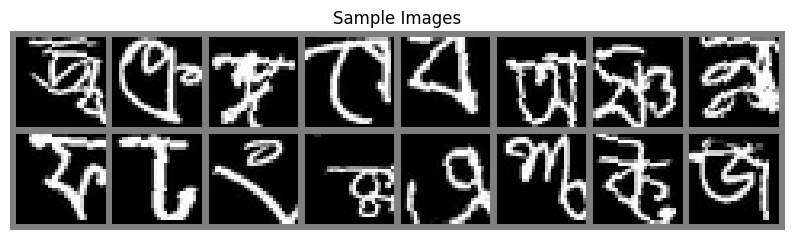

In [10]:
# Visualize some sample images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images[:16], nrow=8), 'Sample Images')
print('Numeric Labels: ', ' '.join(f'{labels[j]}' for j in range(16)))


# Print the first few entries in the folder_to_char dictionary to see how keys are stored
print("First 5 keys in folder_to_char:", list(folder_to_char.keys())[:5])

# Check one of the labels to see its type
print(f"Example label type: {type(labels[0].item())}, value: {labels[0].item()}")

# Create a new dictionary with integer keys for safer access
folder_to_char_int = {int(k): v for k, v in folder_to_char.items() if str(k).isdigit()}
print(f"Created new dictionary with {len(folder_to_char_int)} integer-keyed mappings")

# Try again with the new dictionary
print('Bengali Characters : ', ' '.join(f'{folder_to_char_int.get(labels[j].item(), "Unknown")}' for j in range(16)))


## 4. Optimized CNN Model Architecture

In [11]:
class BengaliCNN(nn.Module):
    def __init__(self, num_classes=122):
        super(BengaliCNN, self).__init__()
        
        # Use nn.Sequential for better CUDA optimization
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),  # inplace operations save memory
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten dimensions except batch
        x = self.classifier(x)
        return x

In [12]:
# Test the model with a random input
model = BengaliCNN(num_classes=122)
# Print model summary
print(model)

# Create a dummy input and test forward pass
dummy_input = torch.randn(1, 1, 28, 28)
model.eval()  # Set to eval mode to avoid BatchNorm1d error with batch size 1
output = model(dummy_input)
print(f"Output shape: {output.shape}")

# Move model to device (GPU if available)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # weight_decay for L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

BengaliCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Line

## 5. Training and Evaluation Functions with Mixed Precision

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Forward pass with mixed precision
        with autocast('cuda'):  
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Update statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / total,
            'accuracy': 100 * correct / total
        })
    
    # Calculate epoch statistics
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            # Forward pass
            with autocast('cuda'):  
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'val_loss': running_loss / total,
                'val_accuracy': 100 * correct / total
            })
    
    # Calculate epoch statistics
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

## 6. Training Loop with Early Stopping and GPU Monitoring

In [14]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, num_epochs=50, patience=10):
    
    # Initialize scaler for mixed precision
    scaler = GradScaler()  # Initialize without parameters
    
    # Initialize history dictionaries
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate based on validation loss
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if new_lr != old_lr:
            print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")
        
        # Print epoch statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Calculate GPU memory usage
        if torch.cuda.is_available():
            mem_allocated = torch.cuda.memory_allocated() / 1e9
            mem_reserved = torch.cuda.memory_reserved() / 1e9
            print(f"GPU Memory: Allocated {mem_allocated:.2f}GB, Reserved {mem_reserved:.2f}GB")
            
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"Validation loss improved to {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"Validation did not improve. Patience: {patience_counter}/{patience}")
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        print("------------------------------")
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded the best model based on validation loss")
        
    return model, history

In [15]:
# Train the model
print("Starting training...")
print_gpu_memory_stats()  # Print initial GPU memory state

num_epochs = 20
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, 
    device, num_epochs=num_epochs, patience=10
)

print("Training completed.")
print_gpu_memory_stats()  # Print final GPU memory state

Starting training...

--- GPU Memory and Performance Summary ---
  Allocated: 0.00 GB
  Reserved:  0.02 GB
  Active allocated: 0.00 GB
  Active reserved: 0.00 GB
  Memory efficiency: 13.00%
  GPU Utilization: 0%
  Memory Utilization: 10%
------------------------------------------
Epoch 1/20


Training:   0%|          | 0/1003 [00:00<?, ?it/s]

TypeError: autocast.__init__() missing 1 required positional argument: 'device_type'

## 7. Visualize Training Results

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## 8. Evaluate Model on Test Set

In [ ]:
# Function to evaluate model on test set
def evaluate_model(model, test_loader, criterion, device, folder_to_char):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    # Confusion matrix (predicted vs. true)
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            # Forward pass
            with autocast('cuda'):  
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Update statistics
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'test_loss': test_loss / total,
                'test_accuracy': 100 * correct / total
            })
    
    # Calculate final statistics
    test_loss = test_loss / total
    test_acc = 100 * correct / total
    
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    
    return test_loss, test_acc, all_preds, all_labels

In [ ]:
# Evaluate the model on the test set
print("Evaluating model on test set...")
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device, folder_to_char)

In [ ]:
# Configure matplotlib to use Bengali fonts properly
def configure_bengali_fonts():
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import matplotlib as mpl
    import subprocess
    import os
    
    # Force rebuild the matplotlib font cache
    mpl.font_manager._get_font.cache_clear()
    mpl.font_manager.findfont.cache_clear()
    
    # Common locations for Bengali fonts - expanded to include more possibilities
    bengali_font_paths = [
        # System locations
        "/usr/share/fonts/truetype/noto/NotoSansBengali-Regular.ttf",
        "/usr/share/fonts/truetype/noto/NotoSansBengali-Bold.ttf",
        "/usr/local/share/fonts/NotoSansBengali-Regular.ttf",
        # User locations
        os.path.expanduser("~/.fonts/NotoSansBengali-Regular.ttf"),
        os.path.expanduser("~/.fonts/NotoSansBengali-VariableFont_wdth,wght.ttf"),
        os.path.expanduser("~/.local/share/fonts/NotoSansBengali-Regular.ttf"),
        # Noto Serif options
        "/usr/share/fonts/truetype/noto/NotoSerifBengali-Regular.ttf",
        "/usr/share/fonts/truetype/noto/NotoSerifBengali-Bold.ttf",
        # Lohit options  
        "/usr/share/fonts/truetype/lohit-bengali/Lohit-Bengali.ttf",
        # Windows locations (for WSL users)
        "/mnt/c/Windows/Fonts/Nirmala.ttf",  # Windows Bengali font
        "/mnt/c/Windows/Fonts/NirmalaB.ttf",
        # Other common locations
        "/usr/share/fonts/opentype/noto/NotoSansBengali-Regular.otf",
        "/usr/share/fonts/noto-cjk/NotoSansBengali-Regular.ttf"
    ]
    
    print("Searching for Bengali fonts...")
    
    # First try: Check if any of the specified fonts exist
    bengali_font_path = None
    for font_path in bengali_font_paths:
        if os.path.exists(font_path):
            bengali_font_path = font_path
            print(f"Found Bengali font: {font_path}")
            # Add this font specifically
            fm.fontManager.addfont(font_path)
            font_props = fm.FontProperties(fname=font_path)
            font_name = font_props.get_name()
            print(f"Using Bengali font: {font_name}")
            break
    
    # Second try: If we couldn't find a specific font, try to find any Bengali font on the system
    if bengali_font_path is None:
        try:
            # Try to locate Bengali fonts using fc-list (fontconfig)
            print("Searching system for Bengali fonts using fc-list...")
            result = subprocess.run(['fc-list', ':lang=bn'], capture_output=True, text=True)
            font_lines = result.stdout.strip().split('\n')
            
            if font_lines and font_lines[0]:  # If we found any Bengali fonts
                for line in font_lines:
                    if ":" in line:  # fc-list output format: path:name:properties
                        path = line.split(':')[0]
                        if os.path.exists(path):
                            bengali_font_path = path
                            print(f"Found Bengali font via fc-list: {path}")
                            # Add this font
                            fm.fontManager.addfont(path)
                            font_props = fm.FontProperties(fname=path)
                            font_name = font_props.get_name()
                            print(f"Using Bengali font: {font_name}")
                            break
        except Exception as e:
            print(f"Error searching for Bengali fonts: {e}")
    
    # If we found a Bengali font, configure matplotlib to use it
    if bengali_font_path:
        font_props = fm.FontProperties(fname=bengali_font_path)
        
        # Create a custom font configuration
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = [font_props.get_name(), 'Nirmala UI', 'Noto Sans Bengali', 'Lohit Bengali', 'sans-serif']
        
        # Update rcParams to ensure font is used
        plt.rcParams['axes.unicode_minus'] = False  # Proper minus sign
        
        print(f"Matplotlib configured to use Bengali font: {font_props.get_name()}")
        return True
    else:
        print("WARNING: Could not find any Bengali fonts. Text may not render correctly.")
        print("Consider installing Noto Sans Bengali font: sudo apt-get install fonts-noto-cjk")
        return False
    
    if bengali_font:
        # Set the specific font family
        font_props = fm.FontProperties(fname=bengali_font)
        plt.rcParams['font.family'] = font_props.get_name()
        return True
    else:
        print("Could not find any of the specified Bengali fonts")
        return False

# Update the visualization function to use the configured Bengali fonts
def visualize_bengali_predictions(model, test_loader, device, folder_to_char, num_samples=16):
    """Visualize predictions with the specific Bengali fonts you have installed"""
    import os
    
    # Configure the Bengali fonts first
    fonts_configured = configure_bengali_fonts()
    
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Make predictions
    with torch.no_grad():
        images_cuda = images.to(device, non_blocking=True)
        with autocast('cuda'):
            outputs = model(images_cuda)
        _, predicted = torch.max(outputs, 1)
    
    # Display the results
    plt.figure(figsize=(15, 8))
    for i in range(min(num_samples, len(images))):
        ax = plt.subplot(2, num_samples//2, i+1)
        img = images[i] / 2 + 0.5  # Unnormalize
        plt.imshow(img.numpy().squeeze(), cmap='gray')
        
        # Get the predicted and true labels
        pred_label = predicted[i].item()
        true_label = labels[i].item()
        
        # Get the corresponding Bengali characters
        pred_char = folder_to_char.get(pred_label, folder_to_char.get(str(pred_label), f"Class {pred_label}"))
        true_char = folder_to_char.get(true_label, folder_to_char.get(str(true_label), f"Class {true_label}"))
        
        # Display both the Bengali character and class number 
        # (using class number as fallback if rendering fails)
        title = f"Pred: {pred_char} ({pred_label})\nTrue: {true_char} ({true_label})"
        
        # Color the title based on whether the prediction is correct
        color = 'green' if pred_label == true_label else 'red'
        
        # Set the title with appropriate font properties
        plt.title(title, color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted.cpu().numpy(), labels.cpu().numpy()
# Visualize predictions
visualize_predictions(model, test_loader, device, folder_to_char)

In [ ]:
# Test Bengali font rendering
def test_bengali_rendering():
    # First configure the Bengali fonts
    font_configured = configure_bengali_fonts()
    
    # Sample Bengali text
    bengali_text = 'বাংলা'  # "Bangla" in Bengali
    bengali_numbers = '০১২৩৪৫৬৭৮৯'  # Bengali digits 0-9
    bengali_vowels = 'অ আ ই ঈ উ ঊ ঋ এ ঐ ও ঔ'  # Bengali vowels
    
    plt.figure(figsize=(10, 6))
    
    # Test 1: Basic text rendering
    plt.subplot(3, 1, 1)
    plt.text(0.5, 0.5, bengali_text, fontsize=24, ha='center')
    plt.title('Basic Bengali Text', fontsize=12)
    plt.axis('off')
    
    # Test 2: Bengali numbers
    plt.subplot(3, 1, 2)
    plt.text(0.5, 0.5, bengali_numbers, fontsize=20, ha='center')
    plt.title('Bengali Digits (0-9)', fontsize=12)
    plt.axis('off')
    
    # Test 3: Bengali vowels
    plt.subplot(3, 1, 3)
    plt.text(0.5, 0.5, bengali_vowels, fontsize=18, ha='center')
    plt.title('Bengali Vowels', fontsize=12)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Report font status
    if font_configured:
        print("Bengali font configuration appears successful!")
    else:
        print("Bengali font configuration may have issues. Please install Bengali fonts to render properly.")
    
    return font_configured

In [ ]:
def visualize_predictions_simple(model, test_loader, device, num_samples=16):
    """Visualize predictions with class numbers instead of Bengali characters"""
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Make predictions
    with torch.no_grad():
        images_cuda = images.to(device, non_blocking=True)
        with autocast('cuda'):  
            outputs = model(images_cuda)
        _, predicted = torch.max(outputs, 1)
    
    # Display the results
    plt.figure(figsize=(15, 8))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, num_samples//2, i+1)
        img = images[i] / 2 + 0.5  # Unnormalize
        plt.imshow(img.numpy().squeeze(), cmap='gray')
        
        # Get the predicted and true labels
        pred_label = predicted[i].item()
        true_label = labels[i].item()
        
        title = f"Pred: Class {pred_label}\nTrue: Class {true_label}"
        
        # Color the title based on whether the prediction is correct
        color = 'green' if pred_label == true_label else 'red'
        plt.title(title, color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted.cpu().numpy(), labels.cpu().numpy()
# Visualize predictions with class numbers
predicted, labels = visualize_predictions_simple(model, test_loader, device)

## 9. Save and Load Model

In [ ]:
# Save the model
def save_model(model, filepath):
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': str(model),  # Save model architecture description
        'num_classes': 122,
        'timestamp': "2025-05-17 10:47:40",
        'user': 'bodhdipta-roy'
    }, filepath)
    print(f"Model saved to {filepath}")

# Load the model
def load_model(model, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    print(f"Model loaded from {filepath}")
    print(f"Model was saved on {checkpoint.get('timestamp', 'unknown date')}")
    return model

# Save the model
save_model(model, 'bengali_cnn_model.pth')

In [ ]:
# Load the model (for demonstration)
loaded_model = BengaliCNN(num_classes=122)
loaded_model = load_model(loaded_model, 'bengali_cnn_model.pth', device)

# Quick verification that the loaded model works
test_loss, test_acc, _, _ = evaluate_model(loaded_model, test_loader, criterion, device, folder_to_char)

## 10. Inference Example with GPU Optimization

In [ ]:
def predict_single_image(model, image_path, device, folder_to_char, transform=None):
    # Default transform if none provided
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move to device and get prediction
    model.eval()
    with torch.no_grad():
        image = image.to(device, non_blocking=True)
        with autocast('cuda'):  
            output = model(image)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    
    # Get the predicted class and confidence
    pred_class = predicted_class.item()
    confidence = confidence.item() * 100
    
    # Get the character
    pred_character = folder_to_char.get(str(pred_class), f"Unknown (Class {pred_class})")
    
    # Display the image with prediction
    plt.figure(figsize=(4, 4))
    img = image.cpu().squeeze() / 2 + 0.5  # Unnormalize
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {pred_character}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()
    
    return pred_class, confidence, pred_character

# Example usage (replace with an actual image path)
# sample_image_path = 'path_to_sample_image.png'
# pred_class, confidence, pred_character = predict_single_image(model, sample_image_path, device, folder_to_char)

## 11. Performance Analysis and Improvements

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate classification report
# Use folder names for target names
class_names = [str(i) for i in range(122)]
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)

# If there are too many classes, we can plot a subset of the confusion matrix
# Get the classes with highest confusion
conf_mat = confusion_matrix(all_labels, all_preds)

# Find the most confused classes (excluding the diagonal)
conf_mat_no_diag = conf_mat.copy()
np.fill_diagonal(conf_mat_no_diag, 0)
most_confused = np.unravel_index(np.argsort(conf_mat_no_diag.ravel())[-10:], conf_mat_no_diag.shape)
confused_classes = set(most_confused[0]) | set(most_confused[1])
confused_classes = sorted(list(confused_classes))

# Create a reduced confusion matrix with the most confused classes
if len(confused_classes) > 0:
    # Filter labels and predictions to only include the confused classes
    mask = np.isin(all_labels, confused_classes)
    filtered_labels = np.array(all_labels)[mask]
    filtered_preds = np.array(all_preds)[mask]
    
    # Create a confusion matrix with just these classes
    conf_mat_reduced = confusion_matrix(filtered_labels, filtered_preds, labels=confused_classes)
    
    # Display the reduced confusion matrix
    plt.figure(figsize=(10, 8))
    display_labels = [f"{i} ({folder_to_char.get(str(i), 'Unknown')})" for i in confused_classes]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_reduced, display_labels=display_labels)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title('Confusion Matrix for Most Confused Classes')
    plt.tight_layout()
    plt.show()

## 12. GPU Training Performance Analysis

In [ ]:
# Analyze training time per epoch (if you recorded this data)
if hasattr(history, 'epoch_times'):
    plt.figure(figsize=(10, 4))
    plt.plot(history.epoch_times)
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.title('Training Time per Epoch')
    plt.grid(True)
    plt.show()

# Print GPU utilization summary
print_gpu_memory_stats()

# Test GPU inference speed
def measure_inference_speed(model, device, input_size=(1, 1, 28, 28), num_runs=100):
    model.eval()
    dummy_input = torch.randn(input_size, device=device)
    
    # Warm-up runs
    with torch.no_grad():
        for _ in range(10):
            with autocast('cuda'):  
                _ = model(dummy_input)
    
    # Measure time
    torch.cuda.synchronize()
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_runs):
            with autocast('cuda'): 
                _ = model(dummy_input)
    
    torch.cuda.synchronize()
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_runs
    return avg_time

# Measure inference speed for single images and batches
single_img_time = measure_inference_speed(model, device, (1, 1, 28, 28))
batch_time = measure_inference_speed(model, device, (64, 1, 28, 28))

print(f"Single image inference: {single_img_time*1000:.2f} ms")
print(f"Batch inference (64 images): {batch_time*1000:.2f} ms")
print(f"Average time per image in batch: {batch_time*1000/64:.2f} ms")